IDRIS

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Loading the dataset

In [5]:
df = pd.read_csv('Alcohol_Sales.csv', index_col = 0, parse_dates = True)

In [6]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [7]:
len(df)

325

Let's check if any null values

In [8]:
df = df.dropna()

In [9]:
len(df)

325

<Axes: xlabel='DATE'>

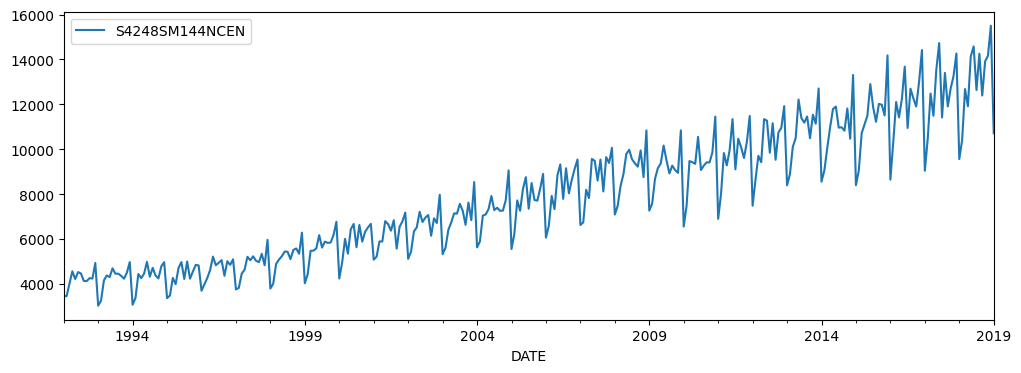

In [10]:
df.plot(figsize = (12,4))

ok we can see a clear trend, Now let's create our train and test set.

In [11]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

The datatype is also an object we also have to convert it to float.

In [12]:
y = df['S4248SM144NCEN'].values.astype(float)

The data is in Months so to grab 1 year we have to select 12 months.

In [13]:
test_size = 12

In [14]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [15]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

The code below is using the MinMaxScaler from scikit-learn to scale the train_set data to be within the range of -1 to 1. Scaling is often done to ensure that all features have a similar scale, which can be beneficial for certain machine learning algorithms.

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler(feature_range = (-1,1))

In [18]:
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [19]:
train_norm.min()

-1.0

In [20]:
train_norm = torch.FloatTensor(train_norm).view(-1)

Defining window size

In [21]:
def input_data(seq,ws):  # ws is the window size
    out = []    # ----> ([0,1,2,3],[4])   ([1,2,3,4],[5]) and so on
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]  # this +1 in the last is our prediction
        out.append((window,label))
    return out

In [22]:
window_size = 12

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_norm,window_size)

len(train_data)

301

In [23]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

# Defining class for our MODEL

In [24]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),  # initializing zero the hidden state
                       torch.zeros(1,1,hidden_size))  # ---> initializing zero the cell state

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

Defining loss and optimizer

In [25]:
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [26]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

Training our model

In [27]:
import time
start_time = time.time()
epochs = 100

for i in range(epochs):

    # tuple-unpack the train_data set
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')


print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.30738068
Epoch:  2 Loss: 0.30543590
Epoch:  3 Loss: 0.33040923
Epoch:  4 Loss: 0.36139333
Epoch:  5 Loss: 0.31017011
Epoch:  6 Loss: 0.32543170
Epoch:  7 Loss: 0.32339713
Epoch:  8 Loss: 0.32664019
Epoch:  9 Loss: 0.31712556
Epoch: 10 Loss: 0.30658299
Epoch: 11 Loss: 0.30092084
Epoch: 12 Loss: 0.29874796
Epoch: 13 Loss: 0.28741750
Epoch: 14 Loss: 0.28644434
Epoch: 15 Loss: 0.28167257
Epoch: 16 Loss: 0.28527236
Epoch: 17 Loss: 0.27642101
Epoch: 18 Loss: 0.27107900
Epoch: 19 Loss: 0.25680256
Epoch: 20 Loss: 0.26686049
Epoch: 21 Loss: 0.26140109
Epoch: 22 Loss: 0.15823142
Epoch: 23 Loss: 0.13160253
Epoch: 24 Loss: 0.00714065
Epoch: 25 Loss: 0.17323932
Epoch: 26 Loss: 0.03556120
Epoch: 27 Loss: 0.00946384
Epoch: 28 Loss: 0.01183267
Epoch: 29 Loss: 0.00653518
Epoch: 30 Loss: 0.00817566
Epoch: 31 Loss: 0.00511373
Epoch: 32 Loss: 0.00062007
Epoch: 33 Loss: 0.00080268
Epoch: 34 Loss: 0.00130354
Epoch: 35 Loss: 0.00262282
Epoch: 36 Loss: 0.00049909
Epoch: 37 Loss: 0.00000007
E

In [33]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [34]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.1696876585483551,
 0.6285980343818665,
 0.513032078742981,
 0.4640275537967682,
 0.8360182642936707,
 0.4432517886161804,
 0.6819539666175842,
 0.6819456815719604,
 0.5366622805595398,
 0.8064723014831543,
 0.9881352782249451,
 0.09855619072914124]

These values are normalised so we have to doinvert tranformation to truly compare it to the test

In [35]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[ 9873.08795868],
       [12557.48420212],
       [11881.48114461],
       [11594.82917593],
       [13770.78883699],
       [11473.30133751],
       [12869.58972773],
       [12869.54126436],
       [12019.70601013],
       [13597.95972753],
       [14660.59730998],
       [ 9457.00443767]])

In [36]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [37]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

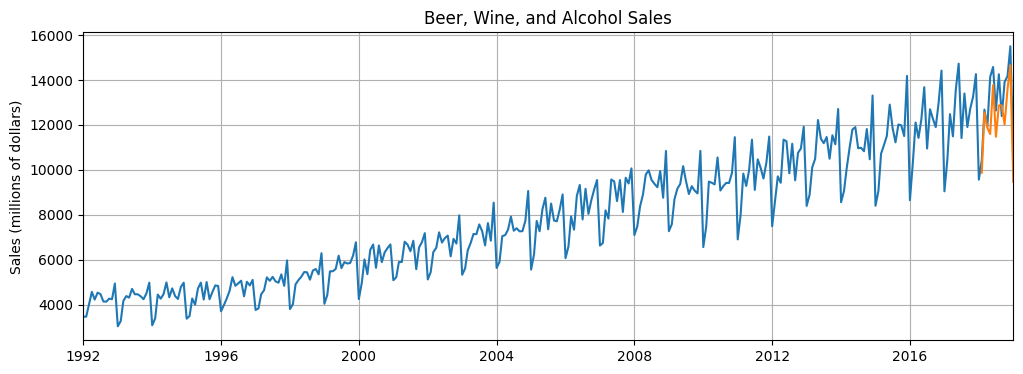

In [38]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

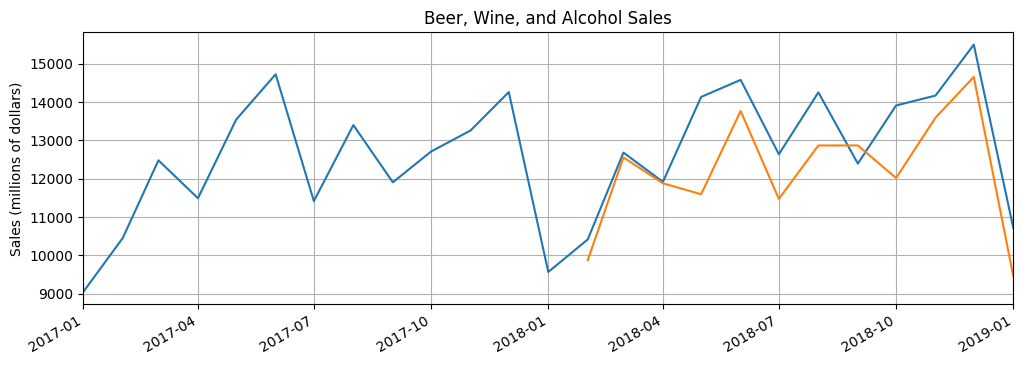

In [39]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [40]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    # train on the full set of sequences
    for seq, y_train in all_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.03550962
Epoch:  2 Loss: 0.02262406
Epoch:  3 Loss: 0.01668942
Epoch:  4 Loss: 0.00929804
Epoch:  5 Loss: 0.00496356
Epoch:  6 Loss: 0.00270616
Epoch:  7 Loss: 0.00101578
Epoch:  8 Loss: 0.00018019
Epoch:  9 Loss: 0.00010228
Epoch: 10 Loss: 0.00046788
Epoch: 11 Loss: 0.00385607
Epoch: 12 Loss: 0.00075604
Epoch: 13 Loss: 0.00048246
Epoch: 14 Loss: 0.00001263
Epoch: 15 Loss: 0.00012106
Epoch: 16 Loss: 0.00000688
Epoch: 17 Loss: 0.00035454
Epoch: 18 Loss: 0.00053668
Epoch: 19 Loss: 0.01618071
Epoch: 20 Loss: 0.00137167
Epoch: 21 Loss: 0.01925191
Epoch: 22 Loss: 0.01705640
Epoch: 23 Loss: 0.02207503
Epoch: 24 Loss: 0.00794768
Epoch: 25 Loss: 0.00202054
Epoch: 26 Loss: 0.00003227
Epoch: 27 Loss: 0.00002733
Epoch: 28 Loss: 0.00057059
Epoch: 29 Loss: 0.00004644
Epoch: 30 Loss: 0.00027158
Epoch: 31 Loss: 0.00055278
Epoch: 32 Loss: 0.00264375
Epoch: 33 Loss: 0.01008381
Epoch: 34 Loss: 0.00927125
Epoch: 35 Loss: 0.00565595
Epoch: 36 Loss: 0.00171771
Epoch: 37 Loss: 0.00222122
E

## Predict future values, plot the result

In [41]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [42]:
# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))


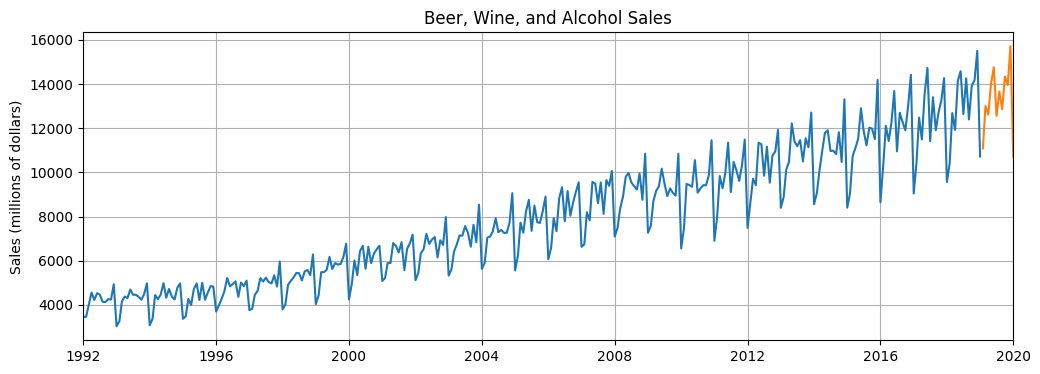

In [43]:
# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

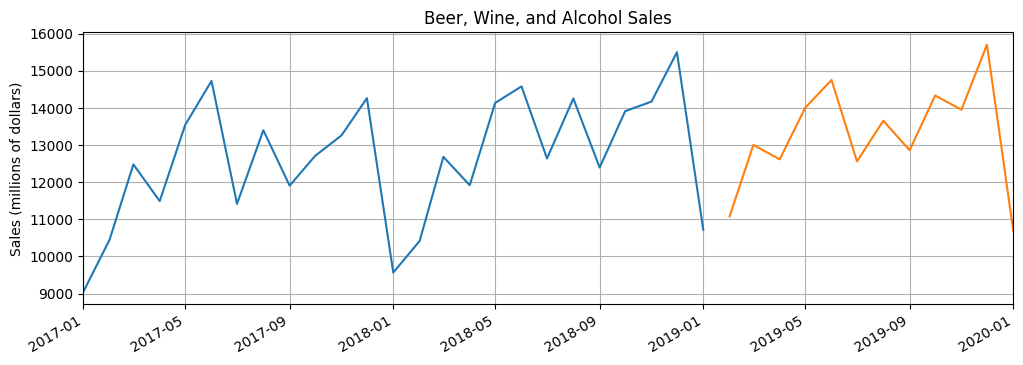

In [44]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()